In [172]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import numpy as np

def views(x):
    return x.view(-1, 784)
mnist_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=0.5, std=0.5),
                                       transforms.Lambda(views)])

data = datasets.MNIST(root='/data/MNIST', download=True, transform=mnist_transforms)

mnist_dataloader = DataLoader(data, batch_size=64, shuffle=True, num_workers=0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [173]:
data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /data/MNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [174]:
test_data = iter(mnist_dataloader)
X = next(test_data)
print(len(X))
X[0].size()

2


torch.Size([64, 1, 28, 28])

In [175]:
class Generator(nn.Module):
  '''
  Generator class. Accepts a tensor of size 100 as input as outputs another
  tensor of size 784. Objective is to generate an output tensor that is
  indistinguishable from the real MNIST digits 
  '''
  
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(nn.Linear(in_features=128, out_features=256),
                                nn.LeakyReLU())
    self.layer2 = nn.Sequential(nn.Linear(in_features=256, out_features=512),
                                nn.LeakyReLU())
    self.layer3 = nn.Sequential(nn.Linear(in_features=512, out_features=1024),
                                nn.LeakyReLU())
    self.output = nn.Sequential(nn.Linear(in_features=1024, out_features=28*28),
                                nn.Tanh())

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.output(x)
    return x

In [176]:
class Discriminator(nn.Module):
  '''
  Discriminator class. Accepts a tensor of size 784 as input and outputs
  a tensor of size 1 as  the predicted class probabilities
  (generated or real data)
  '''

  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(nn.Linear(in_features=28*28, out_features=1024),
                                nn.LeakyReLU())
    self.layer2 = nn.Sequential(nn.Linear(in_features=1024, out_features=512),
                                nn.LeakyReLU())
    self.layer3 = nn.Sequential(nn.Linear(in_features=512, out_features=256),
                                nn.LeakyReLU())
    self.output = nn.Sequential(nn.Linear(in_features=256, out_features=1),
                                nn.Sigmoid())
    
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.output(x)
    return x

In [177]:
D = Discriminator()
G = Generator()
loss = torch.nn.CrossEntropyLoss()
D_optimizer =  torch.optim.Adam(D.parameters(), lr=1.0e-3)
G_optimizer =  torch.optim.Adam(G.parameters(), lr=1.0e-3)

In [178]:
for epoch in range(30):
    for idx, (imgs, _) in enumerate(mnist_dataloader):
        idx += 1
        
        # Обучаем дискриминатор
        # real_inputs - изображения из набора данных MNIST 
        # fake_inputs - изображения от генератора
        # real_inputs должны быть классифицированы как 1, а fake_inputs - как 0
        real_inputs = imgs.to(device)
        real_outputs = D(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)
        noise = (torch.rand(real_inputs.shape[0], 128) - 0.5) / 0.5
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)
        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)
        D_loss = loss(outputs, targets)
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        # Обучаем генератор
        # Цель генератора получить от дискриминатора 1 по всем изображениям
        noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)
        G_loss = loss(fake_outputs, fake_targets)
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        if idx % 100 == 0 or idx == len(mnist_dataloader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, D_loss.item(), G_loss.item()))
    if (epoch+1) % 10 == 0:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1792x28 and 784x1024)

In [ ]:
.torch.randn(100,1,100, device=device).size()

In [113]:
import pytorch_lightning as pl

class GAN(pl.LightningModule):
 
  def __init__(self):
    super().__init__()
    # print(1)
    self.generator = Generator()
    self.discriminator = Discriminator()
    # After each epoch, we generate 100 images using the noise
    # vector here (self.test_noises). We save the output images
    # in a list (self.test_progression) for plotting later.
    self.test_noises = torch.randn(100,1,100, device=device)
    self.test_progression = []
    self.automatic_optimization = False
    

  def forward(self, z):
    """
    Generates an image using the generator
    given input noise z
    """
    #print('2')
    return self.generator(z)

  def generator_step(self, x):
    """
    Training step for generator
    1. Sample random noise
    2. Pass noise to generator to
       generate images
    3. Classify generated images using
       the discriminator
    4. Backprop loss to the generator
    """
    #print('3')
    
    # Sample noise
    z = torch.randn(x.shape[0], 1, 100, device=device)

    # Generate images
    generated_imgs = self(z)

    # Classify generated images
    # using the discriminator
    d_output = torch.squeeze(self.discriminator(generated_imgs))

    # Backprop loss. We want to maximize the discriminator's
    # loss, which is equivalent to minimizing the loss with the true
    # labels flipped (i.e. y_true=1 for fake images). We do this
    # as PyTorch can only minimize a function instead of maximizing
    g_loss = nn.BCELoss()(d_output,
                           torch.ones(x.shape[0], device=device))

    return g_loss

  def discriminator_step(self, x):
    #print('4')
    """
    Training step for discriminator
    1. Get actual images
    2. Predict probabilities of actual images and get BCE loss
    3. Get fake images from generator
    4. Predict probabilities of fake images and get BCE loss
    5. Combine loss from both and backprop loss to discriminator
    """
    
    # Real images
    d_output = torch.squeeze(self.discriminator(x))
    loss_real = nn.BCELoss()(d_output,
                             torch.ones(x.shape[0], device=device))

    # Fake images
    z = torch.randn(x.shape[0], 1, 100, device=device)
    generated_imgs = self(z)
    d_output = torch.squeeze(self.discriminator(generated_imgs))
    loss_fake = nn.BCELoss()(d_output,
                             torch.zeros(x.shape[0], device=device))

    return loss_real + loss_fake

  def training_step(self, batch, batch_idx):
    #print('5')
    X, _ = batch
    plt.imshow(np.reshape(X[0].detach().numpy(),(28,28)))
    g_opt, d_opt = self.optimizers()
     
    g_loss = self.generator_step(X)
    g_opt.zero_grad()
    self.manual_backward(g_loss)
    g_opt.step()
    
    d_loss = self.discriminator_step(X)
    d_opt.zero_grad()
    self.manual_backward(d_loss)
    d_opt.step()
    
    #print(g_loss, d_loss)

  def configure_optimizers(self):
    #print('6')
    g_opt = torch.optim.Adam(self.generator.parameters(), lr=0.001)
    d_opt = torch.optim.Adam(self.discriminator.parameters(), lr=0.001)
    return g_opt, d_opt

  def on_train_epoch_end(self): # , training_step_outputs
    #print('7')
    epoch_test_images = self(self.test_noises)
    self.test_progression.append(epoch_test_images)
#Теперь мы можем обучить наш GAN. Мы будем обучать его с помощью графического процессора в течение 100 эпох.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model = GAN()

trainer = pl.Trainer(max_epochs=2)#, max_epochs=40,accelerator="auto"
trainer.fit(model, mnist_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 1.5 M 
1 | discriminator | Discriminator | 1.5 M 
------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.786    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Error in callback <function flush_figures at 0x0000023C6465E700> (for post_execute):



KeyboardInterrupt



In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [114]:
import numpy as np
from matplotlib import pyplot as plt, gridspec

# Convert images from torch tensor to numpy array
images = [i.detach().cpu().numpy() for i in model.test_progression]

epoch_to_plot = 1
nrow = 4
ncol = 8

# randomly select 10 images for plotting
indexes = np.random.choice(range(100), nrow*ncol, replace=False)

fig = plt.figure(figsize=((ncol+1)*2, (nrow+1)*2)) 
fig.suptitle('Epoch {}'.format(epoch_to_plot), fontsize=30)

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

for i in range(nrow):
    for j in range(ncol):
        idx = i*ncol + j
        img = np.reshape(images[epoch_to_plot-1][indexes[idx]], (28,28))
        ax = plt.subplot(gs[i,j])
        ax.imshow(img, cmap='gray')
        ax.axis('off')

IndexError: list index out of range

<Figure size 1800x1000 with 0 Axes>

In [115]:
np.reshape(model.forward(torch.randn(1,1,100)).detach().numpy(),(28,28))

array([[-1.        , -1.        , -1.        , -1.        ,  1.        ,
         1.        , -1.        , -1.        , -1.        , -1.        ,
         1.        , -1.        , -1.        ,  1.        ,  1.        ,
         1.        ,  1.        , -1.        , -1.        , -1.        ,
         1.        , -1.        , -1.        , -1.        ,  1.        ,
        -1.        , -1.        , -1.        ],
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
         1.        ,  1.        ,  1.        , -1.        ,  1.        ,
        -1.        ,  1.        ,  1.        , -1.        , -1.        ,
         1.        ,  1.        , -1.        ,  1.        , -1.        ,
        -1.        ,  1.        , -1.        ],
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        ,  1.        ,  1.        , -1.        ,
        -1.        , -1.    

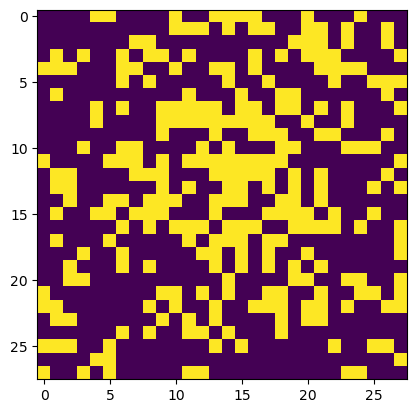

In [136]:
img = np.reshape(model.forward(torch.randn(1,1,100)).detach().numpy(),(28,28))
plt.imshow(img)

In [131]:
torch.randn(1,1,100).detach().numpy()

array([[[ 5.07983446e-01, -8.56134772e-01,  6.58681750e-01,
         -5.56978881e-01,  4.59508568e-01, -1.33551195e-01,
          1.58638585e+00, -3.67085814e-01,  7.08193839e-01,
          2.05746603e+00,  1.57912719e+00,  3.59650582e-01,
         -1.55611351e-01, -1.28941405e+00,  8.13412786e-01,
          3.04984629e-01,  1.17076226e-01, -7.31400728e-01,
          7.24779218e-02, -2.31657958e+00, -7.45728314e-01,
         -2.80001462e-01,  8.60050857e-01, -8.50371718e-01,
          1.25235513e-01,  1.00741494e+00, -2.04857901e-01,
         -1.15286922e+00,  4.12721694e-01,  1.02843940e+00,
          4.00168508e-01,  6.34475276e-02,  2.54313052e-01,
          1.00115073e+00, -8.31082985e-02,  1.27650928e+00,
          4.12714541e-01, -9.92530659e-02, -1.68523073e+00,
          2.28361294e-01,  2.34285280e-01,  1.47009119e-01,
          1.43849182e+00, -1.52908236e-01,  3.79862100e-01,
         -9.10960436e-01, -9.12463605e-01, -1.11210018e-01,
         -2.93070078e-01, -3.76423985e-0

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

mnist_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=0.5, std=0.5),
                                       transforms.Lambda(lambda x: x.view(-1, 784))])

data = datasets.MNIST(root='/data/MNIST', download=True, transform=mnist_transforms)

mnist_dataloader = DataLoader(data, batch_size=32, shuffle=True, num_workers=0) 
class Generator(nn.Module):
  '''
  Generator class. Accepts a tensor of size 100 as input as outputs another
  tensor of size 784. Objective is to generate an output tensor that is
  indistinguishable from the real MNIST digits 
  '''
  
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(nn.Linear(in_features=100, out_features=256),
                                nn.LeakyReLU())
    self.layer2 = nn.Sequential(nn.Linear(in_features=256, out_features=512),
                                nn.LeakyReLU())
    self.layer3 = nn.Sequential(nn.Linear(in_features=512, out_features=1024),
                                nn.LeakyReLU())
    self.output = nn.Sequential(nn.Linear(in_features=1024, out_features=28*28),
                                nn.Tanh())

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.output(x)
    return x
  
class Discriminator(nn.Module):
  '''
  Discriminator class. Accepts a tensor of size 784 as input and outputs
  a tensor of size 1 as  the predicted class probabilities
  (generated or real data)
  '''

  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(nn.Linear(in_features=28*28, out_features=1024),
                                nn.LeakyReLU())
    self.layer2 = nn.Sequential(nn.Linear(in_features=1024, out_features=512),
                                nn.LeakyReLU())
    self.layer3 = nn.Sequential(nn.Linear(in_features=512, out_features=256),
                                nn.LeakyReLU())
    self.output = nn.Sequential(nn.Linear(in_features=256, out_features=1),
                                nn.Sigmoid())
    
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.output(x)
    return x

In [ ]:
import pytorch_lightning as pl

class GAN(pl.LightningModule):

  def __init__(self):
    super().__init__()
    self.generator = Generator()
    self.discriminator = Discriminator()
    # After each epoch, we generate 100 images using the noise
    # vector here (self.test_noises). We save the output images
    # in a list (self.test_progression) for plotting later.
    self.test_noises = torch.randn(100,1,100, device=device)
    self.test_progression = []

  def forward(self, z):
    """
    Generates an image using the generator
    given input noise z
    """
    return self.generator(z)

  def generator_step(self, x):
    """
    Training step for generator
    1. Sample random noise
    2. Pass noise to generator to
       generate images
    3. Classify generated images using
       the discriminator
    4. Backprop loss to the generator
    """
    
    # Sample noise
    z = torch.randn(x.shape[0], 1, 100, device=device)

    # Generate images
    generated_imgs = self(z)

    # Classify generated images
    # using the discriminator
    d_output = torch.squeeze(self.discriminator(generated_imgs))

    # Backprop loss. We want to maximize the discriminator's
    # loss, which is equivalent to minimizing the loss with the true
    # labels flipped (i.e. y_true=1 for fake images). We do this
    # as PyTorch can only minimize a function instead of maximizing
    g_loss = nn.BCELoss()(d_output,
                           torch.ones(x.shape[0], device=device))

    return g_loss

  def discriminator_step(self, x):
    """
    Training step for discriminator
    1. Get actual images
    2. Predict probabilities of actual images and get BCE loss
    3. Get fake images from generator
    4. Predict probabilities of fake images and get BCE loss
    5. Combine loss from both and backprop loss to discriminator
    """
    
    # Real images
    d_output = torch.squeeze(self.discriminator(x))
    loss_real = nn.BCELoss()(d_output,
                             torch.ones(x.shape[0], device=device))

    # Fake images
    z = torch.randn(x.shape[0], 1, 100, device=device)
    generated_imgs = self(z)
    d_output = torch.squeeze(self.discriminator(generated_imgs))
    loss_fake = nn.BCELoss()(d_output,
                             torch.zeros(x.shape[0], device=device))

    return loss_real + loss_fake

  def training_step(self, batch, batch_idx, optimizer_idx):
    X, _ = batch

    # train generator
    if optimizer_idx == 0:
      loss = self.generator_step(X)
    
    # train discriminator
    if optimizer_idx == 1:
      loss = self.discriminator_step(X)

    return loss

  def configure_optimizers(self):
    g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=0.0002)
    d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002)
    return [g_optimizer, d_optimizer], []

  def on_train_epoch_end(self, training_step_outputs):
    epoch_test_images = self(self.test_noises)
    self.test_progression.append(epoch_test_images)
#Теперь мы можем обучить наш GAN. Мы будем обучать его с помощью графического процессора в течение 100 эпох.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = GAN()

trainer = pl.Trainer(max_epochs=100)
trainer.fit(model, mnist_dataloader)

In [ ]:
for i in torch.manual_seed(42):
    print(i)